In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import argnotnan, set_spines_visible, generate_video_with_text, create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack

import trackpy as tp
import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

## three recordings
1) 2024_0409_183417_103.MP4 - Dlow, 60hz, great position for central current! and side vortex > extents
2) 2024_0409_183630_104.MP4 - Dhigh, 60hz, >2min, many many particles and many captures, dorsal view, clean view, poops, moves
3) 2024_0409_183844_105.MP4 - similar to (2) but shorter

In [3]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0409_183630_104.MP4"  
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = vid_props
print(vid_props)

results_save_path = f"./data/results/whirling/{vid_filename.split('.')[0]}/"
os.makedirs(results_save_path, exist_ok=True)

pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 1)
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), frames_filepaths, export_frames) if EXPORT_FRAMES else None


(60, 7833, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61


In [4]:
img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0409_183630_104/*.jpg
    Length: 7833 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8

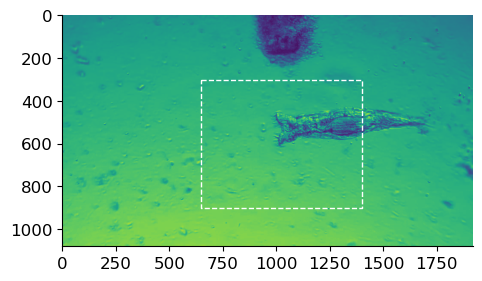

In [5]:
zoom_in = [650, 1400, 300, 900] 

plt.figure()
plt.imshow(frames[2500])
plot_bbox(zoom_in)

In [6]:
# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = False
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None

In [7]:
capture_frames = [[0,44],[46,85],[140, 176],[271,306],[439,482],[549,575],[596,627],[735,764],[812,850],[955,993],[1014,1048],[1049,1080],[1214,1254],[1338,1375],[1600,1630],
                  [1693,1723],[1829,1858],[1859,1912],[2133,2191],[2244,2269],[2472,2520],[2534,2568],[2820,2864],[3040,3077],[3156,3187],[3362,3390],[3515,3545],
                  [3601,3671],[3718,3739],[3751,3788],[3899,3930],[4061,4090],[4209,4243],[4283,4306],[4565,4619],[4628,4662],
                  [4794,4845],[4851,4883],[5009,5050],[5597,5627],[5636,5687],[5704,5745],[5736,5818],[5879,5923],[6529,6578],[6724,6767],[6896,6935],[7695,7723]]
#[1159,1186]
#[2820,2864] while moving
# [1859,1912]**
len(capture_frames)

48

# 2024_0409_183844_105.MP4

In [8]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0409_183844_105.MP4"  
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = vid_props
print(vid_props)

results_save_path = f"./data/results/whirling/{vid_filename.split('.')[0]}/"
os.makedirs(results_save_path, exist_ok=True)

pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 1)
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), frames_filepaths, export_frames) if EXPORT_FRAMES else None

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))
frames

(60, 1998, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61


(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0409_183844_105/*.jpg
    Length: 1998 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8

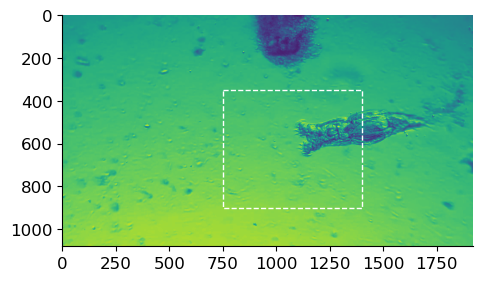

In [9]:
zoom_in = [750, 1400, 350, 900] 

plt.figure()
plt.imshow(frames[1900])
plot_bbox(zoom_in)

In [10]:
# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = False
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None

In [11]:
# original
capture_frames = [[0,38],[60,95],[372,398],[426,466],[437,490],[542,579],[735,765],[919,975],
                  [975,1016],[1167,1191],[1305,1349],[1553,1611],[1737,1777],[1817,1899],
                  [1863,1913]]
# selected only
capture_frames = [[60,95],[1305,1349],[1553,1611],[1737,1777],[1817,1899],[1863,1913]]
# [1167,1191] same traj, one is taken, the other not!; [1553,1611] smt weird; [1737,1777]**; [1817,1899], two captures, far away

In [12]:
from PIL import Image
zoom_in_pil = (750, 350, 1400, 900) # (left, upper, right, lower)
capture_frames = [[60,95],[1305,1349],[1553,1611],[1737,1777],[1817,1899],[1863,1913]]

food_capture_dir = f"./data/images/{vid_filename.split('.')[0]}_food_capture_frames/"
os.makedirs(food_capture_dir, exist_ok=True)

SAVE_CUT = False
if SAVE_CUT:
    for cut in capture_frames:
        idx = np.arange(cut[0], cut[1]+1)
        cut_imgs = [Image.open(img_fp[i]).crop(zoom_in_pil) for i in idx]
        des_fps = [os.path.join(food_capture_dir, os.path.basename(img_fp[i])) for i in idx]
        for img, des in zip(cut_imgs, des_fps):
            img.save(des)

In [13]:
SAVE_CAPTURE_VIDEO = False
if SAVE_CAPTURE_VIDEO:
    img_fp = sorted([os.path.join(food_capture_dir, f) for f in os.listdir(food_capture_dir) if f.endswith(".jpg")])
    cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
    text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0, color=(0,0,0), thickness=2)
    video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_food_capture.mp4"
    vid_params = dict(filename=video_save_fpath, 
                    fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                    fps=fps, 
                    frameSize=(cut_width, cut_height), 
                    isColor=True)

    generate_video_with_text(vid_params, img_fp, text_params, bbox=None) if SAVE_CAPTURE_VIDEO else None

# Start Particle Trajectory Analysis

In [40]:
df = pd.read_csv("./data/csvs/metadata_food_capture_0409_105_final.csv"); print(df.columns)
df = df[df.particle != 6]

# x and y pos
df["cm"] = df["cm"].apply(eval)  # tuples stored as strings, tranform back to tuples
df[["x", "y"]] = pd.DataFrame(df["cm"].to_list(), index=df.index)

# change of x and y
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)

# group according to particle
grouped = df.groupby("particle").apply(lambda x: x[["x", "y", "v"]].to_numpy())
groups = {category: {"x": values.T[0], "y": values.T[1], "v": values.T[2]} for category, values in grouped.items()}
prts = df.particle.unique()

ccols = ["lightsalmon", "teal", "lightblue", "slategrey", "lightgray", "lightgreen", "purple", "crimson","dimgrey"]
global_vminmax = (round(df.v.min(),0), round(df.v.max(),0))
#global_vminmax = (0, 40)
print("max velovity:", global_vminmax)
print(prts)
print(len(prts))

Index(['Unnamed: 0', 'img_idx', 'ids', 'fns', 'bbox', 'frame', 'particle',
       'img_fp', 'cm'],
      dtype='object')
max velovity: (0.0, 56.0)
[1 2 3 4 5 9 8 7]
8


In [48]:
print(np.nanmin(df.v.values), 40 / mpp * fps)

0.0 1454.5454545454545


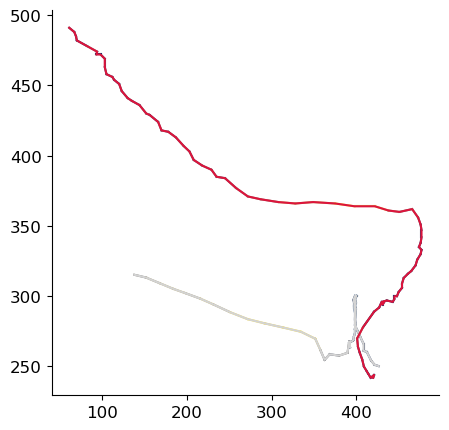

In [113]:
fig, ax = plt.subplots(figsize=(5,5))
for prt in [5,8]:#prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v))
    #c_, _ = create_scalarmappable("plasma", argnotnan(v))
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax)
    ax.plot(x[1:], y[1:], "-", color=ccols[prt-1])

In [42]:
# load masks of first images
first_frames = df.reset_index().drop_duplicates(subset='particle', keep='first').index.values
mask_dir = "./data/seg_masks/2024_0409_183844_105_food_capture_masks/"
mask_fps = [f for f in sorted(os.listdir(mask_dir))]
mask_fp = [os.path.join(mask_dir, mask_fps[ff]) for ff in first_frames]
contour_list = get_contours_from_segmasks(mask_fp)
df_stats = get_contour_stats(contour_list)

0.0 2032.7890704543545


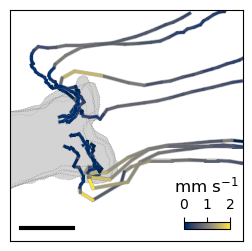

In [64]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
SAVE_FIGURES = False

ax_params = dict(xlim=(-370, 0), ylim=(-125, 200), xticks=[],yticks=[]) #
normalize = True

fig, ax = plt.subplots(figsize=(3,3))
for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt.copy())
    if normalize:
        cnt[:,0] = cnt[:,0] - df_stats.loc[nth, "centroid_x"]
        cnt[:,1] = cnt[:,1] - df_stats.loc[nth, "centroid_y"]
    ax.fill_between(cnt[:,0], cnt[:,1], facecolor="lightgray")  #, lw=1, edgecolor="gray", linestyle="--")
    ax.plot(cnt[:,0], cnt[:,1], ":", color="gray", alpha=.5, lw=.5)

for nth, prt in enumerate(prts):
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v), global_vminmax)
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        y = y - df_stats.loc[nth, "centroid_y"]
    ax.plot(x[1:], y[1:], "-", lw=3, color="gray", alpha=.5)
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=2)

ax.set(**ax_params); ax.set_aspect('equal', adjustable='datalim'); 
ax.invert_xaxis()

vvals = df.v.values / mpp * fps
print(np.nanmin(vvals), np.nanmax(vvals))
# colorbar as inset axes
_, sm = create_scalarmappable("cividis", argnotnan(df.v.values), vminmax=global_vminmax)
axin = inset_axes(ax, width="20%", height="3%", loc="lower right", borderpad=.75)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, int(global_vminmax[1]/2), int(global_vminmax[1])])
cbar.set_ticklabels(["0", "1", "2"], fontsize=10)

cbar.set_label("mm s$^{-1}$", fontsize=12)
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")
set_spines_visible(ax=ax)
plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(-100, -125), linewidth=3, fontsize=None)
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_with_mask.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

1447.0 ± 432.0
370.7 ± 29.7
[13, 19, 15, 17, 11, 13, 38, 12]
3.4 ± 22.9 range=[-33.3-38.1]
36.8 ± 17.9
234.0 ± 109.0
10.020732550103663
144.7478428818312 27.703536611266145
20.6 ± 11.4 range=[-2.7-40.2]


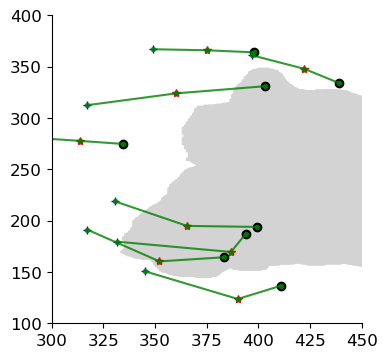

In [163]:
maxv = [np.max(argnotnan(groups[prt]["v"])) for prt in prts]

max_idx = [np.nanargmax(groups[prt]["v"]) for prt in prts]
max_x = [groups[prt]["x"][max_idx[nth]] for nth, prt in enumerate(prts)]
max_y = [groups[prt]["y"][max_idx[nth]] for nth, prt in enumerate(prts)]

max_x_prev = [groups[prt]["x"][max_idx[nth]-1] for nth, prt in enumerate(prts)]
max_y_prev = [groups[prt]["y"][max_idx[nth]-1] for nth, prt in enumerate(prts)]

max_x_next = [groups[prt]["x"][max_idx[nth]+1] for nth, prt in enumerate(prts)]
max_y_next = [groups[prt]["y"][max_idx[nth]+1] for nth, prt in enumerate(prts)]

# x,y position 50ms after the peak
x_at_50 = [groups[prt]["x"][max_idx[nth]+4] for nth, prt in enumerate(prts)]
y_at_50 = [groups[prt]["y"][max_idx[nth]+4] for nth, prt in enumerate(prts)]

print(round(np.mean(maxv) / mpp * fps,0), "±", round(np.std(maxv) / mpp * fps,0))
print(round(np.mean(max_x),1), "±", round(np.std(max_x),1))
print(max_idx)

fig, ax = plt.subplots(figsize=(4,4))

for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt.copy())
    ax.fill_between(cnt[:,0], cnt[:,1], facecolor="lightgray")

plt.plot(max_x, max_y, "*r")
plt.plot(max_x_prev, max_y_prev, "+b")
plt.plot(max_x_next, max_y_next, "ok")

max_trajs = []
for nth in range(len(max_x)):
    max_trajs.append([max_x_prev[nth], max_x[nth], max_x_next[nth], max_y_prev[nth], max_y[nth], max_y_next[nth]])

max_trajs = np.array(max_trajs)
for nth in range(len(max_x)):
    plt.plot(max_trajs[nth,:3], max_trajs[nth,3:], ".-g", alpha=.8)

plt.xlim(300,450), plt.ylim(100, 400)
# Project X value onto line defining the coronal plane

x1, y1 = 330, 155  # Example point 1 on the line
x2, y2 = 400, 340  # Example point 2 on the line

# Slope of the line
m = (y2 - y1) / (x2 - x1)

# Intercept of the line
c = y1 - m * x1

def project_point_on_line(x0, y0, m, c):
    # Line equation: y = mx + c
    # Perpendicular slope: -1/m
    # Perpendicular line equation through (x0, y0): y - y0 = (-1/m)(x - x0)
    
    # Solving for intersection (x_proj, y_proj)
    x_proj = (x0 + m * y0 - m * c) / (m**2 + 1)
    y_proj = (m * x_proj + c)
    
    return x_proj, y_proj

distances = []
x_distances = []
for x0, y0 in zip(max_x, max_y):
    x_proj, y_proj = project_point_on_line(x0, y0, m, c)
    distance = np.sqrt((x0 - x_proj)**2 + (y0 - y_proj)**2)
    x_distance = x0 - x_proj # x_distance = abs(x0 - x_proj)
    x_distances.append(x_distance)
    distances.append(distance)

x_distances = np.array(x_distances)

print(round(np.mean(x_distances / mpp),1), "±", round(np.std(x_distances / mpp),1), f"range=[{round(np.min(x_distances / mpp),1)}-{round(np.max(x_distances / mpp),1)}]")
print(round(np.mean(distances),1), "±", round(np.std(distances),1))

max_v_next = [groups[prt]["v"][max_idx[nth]+4] for nth, prt in enumerate(prts)]
#print(max_v_prev)
print(round(np.mean(max_v_next) / mpp * fps,0), "±", round(np.std(max_v_next) / mpp * fps,0))

#max_v_tail = [np.nanmean(groups[prt]["v"][np.arange(max_idx[nth]+4, max_idx[nth]+12)]) for nth, prt in enumerate(prts)]
max_v_tail = [np.nanmean(groups[prt]["v"][max_idx[nth]+5:]) for nth, prt in enumerate(prts)]
(1000/fps) * 3

round(np.mean(max_v_next) / mpp * fps,0)/1447*100
print(round(np.mean(max_v_tail) / mpp * fps,0)/1447*100)
print(np.mean(max_v_tail) / mpp * fps, np.std(max_v_tail) / mpp * fps)

x_distances_at_50 = []
for x0, y0 in zip(x_at_50, y_at_50):
    x_proj, y_proj = project_point_on_line(x0, y0, m, c)
    distance = np.sqrt((x0 - x_proj)**2 + (y0 - y_proj)**2)
    x_distance = x0 - x_proj # x_distance = abs(x0 - x_proj)
    x_distances_at_50.append(x_distance)

x_distances_at_50 = np.array(x_distances_at_50)
print(round(np.mean(x_distances_at_50 / mpp),1), "±", round(np.std(x_distances_at_50 / mpp),1), f"range=[{round(np.min(x_distances_at_50 / mpp),1)}-{round(np.max(x_distances_at_50 / mpp),1)}]")


In [82]:
stacked= list()
for cut in capture_frames:
    idx = np.arange(cut[0], cut[1]+1)
    cut_imgs = [np.array(Image.open(img_fp[i]).crop(zoom_in_pil)) for i in idx]
    stacked.append(np.stack(cut_imgs))

In [103]:
df[df.frame==1553].particle.unique()
p5 = df[df.particle==5].frame.tolist()
p8 = df[df.particle==8].frame.tolist()
set5, set8 = set(p5), set(p8)

union = set5.union(set8)
intersection_set = set5.intersection(set8)
#print(len(list(set(p5))), len(list(set(p8))), len(list(set(p5 + p8))))
print(intersection_set)

set()


In [104]:
df[df.particle.isin([5,8])].frame.unique()  # both in 4th capture event: [1817,1899], vorletzte > OR NOT!!!
# prt 5 is in earlier capture event: [[60,95],[1305,1349],[1553,1611],[1737,1777],[1817,1899],[1863,1913]]

array([1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563,
       1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574,
       1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585,
       1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596,
       1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607,
       1608, 1609, 1610, 1611, 1817, 1818, 1819, 1820, 1821, 1822, 1823,
       1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834,
       1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845,
       1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856,
       1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867,
       1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878,
       1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889,
       1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900])

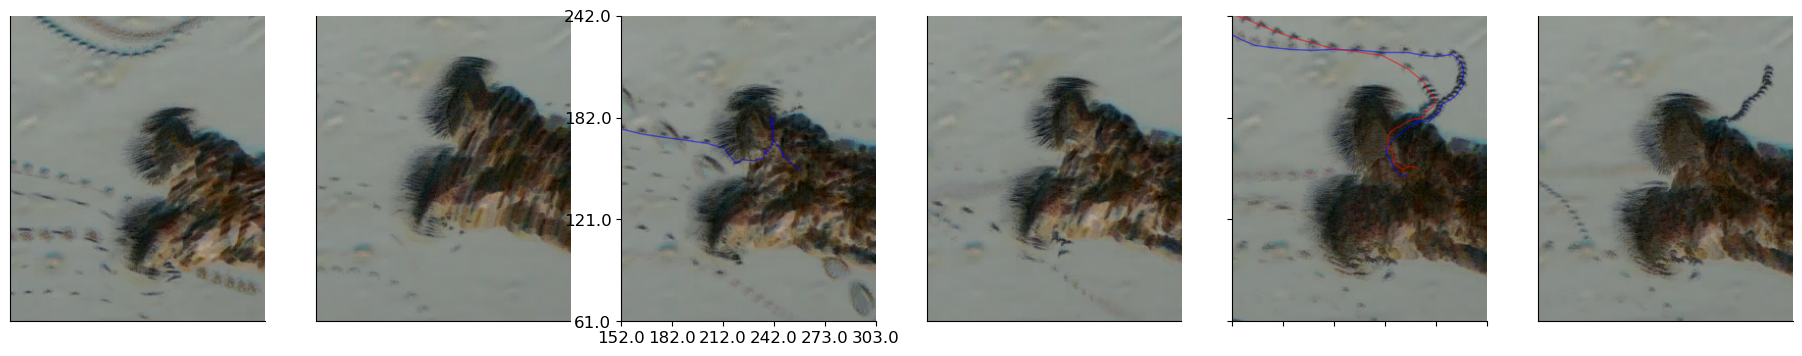

In [176]:
#s_stacked = np.median(stacked[0], axis=0)
xticks_ = np.array([250, 300, 350, 400, 450, 500])
xticklabels_ = map(str, np.round(xticks_ / mpp,0))
yticks_ = np.array([100, 200, 300, 400])
yticklabels_ = map(str, np.round(yticks_ / mpp,0))


ax_params = dict(xlim=(-370, 0), ylim=(-125, 200), xticks=[],yticks=[]) #
# 6 frame seq > got n=8 prts
fig, ax = plt.subplots(1, len(stacked), figsize=(3+20,3+10))
for nth, simg in enumerate(stacked):
    s_stacked = np.min(simg, axis=0) # s_stacked = np.min(stacked[0], axis=0)
    mean_image = np.clip(s_stacked, 0, 255)  # Clip values to the valid range
    mean_image = mean_image.astype(np.uint8)
    ax[nth].imshow(mean_image)
    ax[nth].set(xlim=(250,500), ylim=(100,400),xticks=[],yticks=[])
    
    if nth == 2:
        x, y = df.loc[df.particle==5, ["x", "y"]].T.values
        ax[nth].plot(x,y,"-b", alpha=.5, lw=1)
        ax[nth].set(xlim=(250,500), ylim=(100,400), xticks=xticks_, yticks=yticks_, xticklabels=list(xticklabels_), yticklabels=list(yticklabels_))

    if nth == 4:
        x, y = df.loc[df.particle==8, ["x", "y"]].T.values
        ax[nth].plot(x,y,"-b", alpha=.5, lw=1)
        x, y = df.loc[df.particle==7, ["x", "y"]].T.values
        ax[nth].plot(x,y,"-r", alpha=.5, lw=1)
        ax[nth].set(xlim=(250,500), ylim=(100,400), xticks=xticks_, yticks=yticks_, xticklabels=list(xticklabels_), yticklabels=list(yticklabels_))
    #ax.set(**ax_params); 
    
# BY EYE - CILIA 15 µm LONG

# overlay the mask / masybe subtract it to get the cilia field out
# or subtract median from each image, then min, then visualize
# get proper labels in µm on the axes
# plot traced particles
# plot max velo position of particles
# for prt in prts:
#     x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
#     plt.scatter(x,y, alpha=.75, s=5)

# for prt in prts:
#     x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
#     idx = np.argmax(v)  # have to ignore nanas????
#     print(idx)
#     plt.scatter(x[idx], y[idx], alpha=1, s=20, marker="*")

(0, 40)


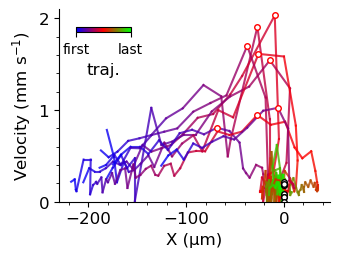

In [20]:
print(global_vminmax)
fig, ax = plt.subplots(figsize=(3.5,2.5))

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        x = x - x[-1]
    #ax.plot(x / mpp, v, "-", lw=1.5, color=ccols[prt-1], alpha=.8)
    c_, _ = create_scalarmappable("brg", np.arange(0, len(x)))
    plot_colorline(x / mpp, v / mpp * fps / 1000, colors=c_, alpha=.8)

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        x = x - x[-1]
    ax.plot(x[np.where(v==np.nanmax(v))[0][0]] / mpp, np.nanmax(v) / mpp * fps / 1000, "o", mfc="w", ms=4, color="r")
    ax.plot(x[-1] / mpp, v[-1] / mpp * fps / 1000, "o", mfc="w", ms=4, color="k")
    #ax.plot(x[1] / mpp, v[1], "o", mfc="w", ms=4, color=ccols[prt-1])

_, sm = create_scalarmappable("brg", np.arange(0,51))
axin = inset_axes(ax, width="20%", height="3%", loc="upper left", borderpad=1.05)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 50])
cbar.set_ticklabels(["first", "last"], fontsize=10)

cbar.set_label("traj.", fontsize=12)
axin.xaxis.set_ticks_position("bottom")
axin.xaxis.set_label_position("bottom")

ax.set(xlabel=("X (µm)"), ylabel=("Velocity (mm s$^{-1}$)"), ylim=(0,2.1), yticks=(0,1,2));
ax.minorticks_on()
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_against_X.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

[(-200.0, 200.0)]

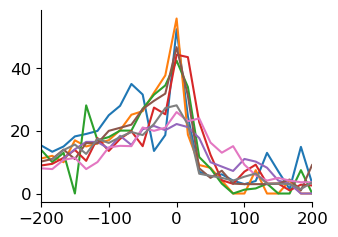

In [34]:
normalized_data = []
vmax_vals = []
for prt in prts:
    v = groups[prt]["v"]
    v_non_nan = v[~np.isnan(v)]#v.dropna().values
    ctime = np.arange(len(v_non_nan))
    idx_max = np.argmax(v_non_nan)
    timeidx = ctime[idx_max]
    
    # Normalize time
    norm_time = (ctime - timeidx) / fps * 1000
    normalized_data.append((norm_time, v_non_nan))
    vmax_vals.append(v_non_nan[idx_max])

fig, ax = plt.subplots(figsize=(3.5,2.5))

for t, v in normalized_data:
    ax.plot(t, v)

ax.set(xlim=(-200, 200))

In [35]:
vmax_vals

[52.478567053607705,
 55.90169943749474,
 42.43819034784589,
 44.355992830732596,
 22.20360331117452,
 46.75467891024384,
 26.019223662515376,
 28.178005607210743]

# NEXT PLOT WITH % OF MAX > EXPONETNIAL????

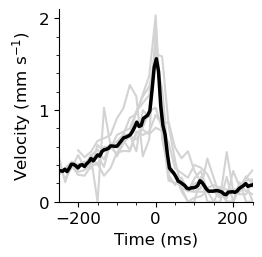

In [33]:
from scipy.interpolate import interp1d

all_times = np.concatenate([t for t, _ in normalized_data])
common_time = np.linspace(all_times.min(), all_times.max(), num=250)  # Adjust the number of points as needed

# Interpolate signals to common time
interpolated_signals = []

for t, v in normalized_data:
    interpolator = interp1d(t, v, bounds_error=False, fill_value=np.nan)
    interpolated_signal = interpolator(common_time)
    interpolated_signals.append(interpolated_signal)

# Convert to DataFrame for easier manipulation
interpolated_df = pd.DataFrame(interpolated_signals).T
interpolated_df.columns = prts

# Compute the mean signal, ignoring NaNs
mean_signal = interpolated_df.median(axis=1, skipna=True)

fig, ax = plt.subplots(figsize=(2.5,2.5))

for t, v in normalized_data:
    ax.plot(t, v / mpp * fps / 1000, lw=1.5, color="lightgray")  # Plot original signals with some transparency

ax.plot(common_time, mean_signal / mpp * fps / 1000, color="k", linewidth=2.5, label='Mean Signal')
ax.set(xlabel=("Time (ms)"), ylabel=("Velocity (mm s$^{-1}$)"), ylim=(0,2.1), yticks=(0,1,2), xlim=(-250, 250));
ax.minorticks_on()
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_against_time_aligned_to_maxV.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

In [31]:
interpolated_df

,1,2,3,4,5,9,8,7
0,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,6.238912,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,6.477824,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,6.670823,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,5.624145,NaN
...,...,...,...,...,...,...,...,...
245,NaN,NaN,NaN,NaN,5.984580,NaN,NaN,NaN
246,NaN,NaN,NaN,NaN,5.033951,NaN,NaN,NaN
247,NaN,NaN,NaN,NaN,5.032211,NaN,NaN,NaN
248,NaN,NaN,NaN,NaN,5.065615,NaN,NaN,NaN


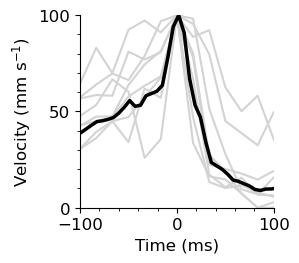

In [30]:
fig, ax = plt.subplots(figsize=(2.5,2.5))

for t, v in normalized_data:
    sig = v / mpp * fps / 1000
    ax.plot(t, sig / np.max(sig) * 100, lw=1.5, color="lightgray")  # Plot original signals with some transparency

msig = mean_signal / mpp * fps / 1000
ax.plot(common_time, msig / np.max(msig) * 100, color="k", linewidth=2.5)
ax.set(xlabel=("Time (ms)"), ylabel=("Velocity (mm s$^{-1}$)"), ylim=(0,100), yticks=(0,50,100), xlim=(-100, 100));
ax.minorticks_on()



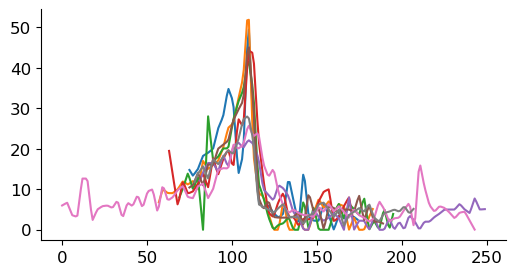

In [20]:
plt.plot(interpolated_df)

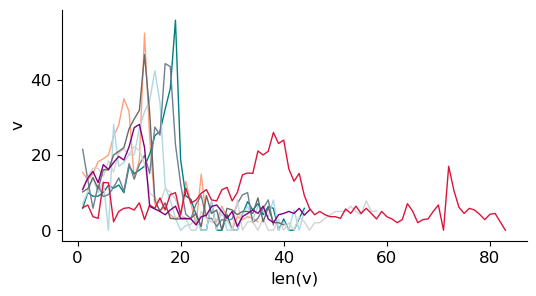

In [21]:
for prt in prts:
    v = groups[prt]["v"]
    idxmax = np.argmax(v)
    

fig, ax = plt.subplots(figsize=(6,3))
for prt in prts:
    v = groups[prt]["v"]
    ax.plot(np.arange(len(v)), v, "-", lw=1, mfc="w", ms=4, color=ccols[prt-1])
ax.set(xlabel=("len(v)"), ylabel=("v"));

# color line from first to last traj point, all same cmap ie gray or coolwarm

# Add Particle TRACKING

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_12056/1489878555.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df_.groupby('x_bins')['v'].agg(['mean', 'std']).reset_index()


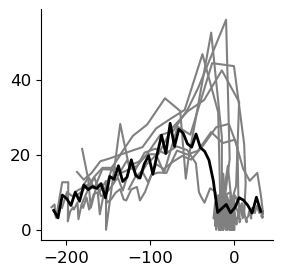

In [22]:
xs, vs = [], []
d_ = {"x" : [], "v" : []}
for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        x = x - x[-1]
    
    d_["x"].extend(x / mpp)
    d_["v"].extend(v)

df_ = pd.DataFrame.from_dict(d_).dropna(subset="v")
xmin, xmax = df_.x.min(), df_.x.max()
bins = np.linspace(xmin, xmax, 50)

df_['x_bins'] = pd.cut(df_['x'], bins)

# Group by the bins and calculate mean and std for 'v' values
binned_stats = df_.groupby('x_bins')['v'].agg(['mean', 'std']).reset_index()

# Extract the center of each bin for plotting or further analysis
binned_stats['bin_center'] = binned_stats['x_bins'].apply(lambda x: x.mid)

fig, ax = plt.subplots(figsize=(3,3))

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        x = x - x[-1]
    ax.plot(x / mpp, v, "-", lw=1.5, mfc="w", ms=4, color="gray")

ax.plot(binned_stats['bin_center'], binned_stats['mean'], "-k", lw=2)

Frame([[133.6491, 133.6491, 132.5049, ..., 128.3587, 128.3587, 128.3587],
       [133.6491, 133.6491, 132.5049, ..., 128.3587, 128.3587, 128.3587],
       [134.6491, 134.6491, 133.5049, ..., 128.5029, 128.5029, 128.5029],
       ...,
       [163.8578, 163.8578, 162.6491, ..., 154.5808, 154.0779, 154.6491],
       [163.8578, 163.8578, 162.6491, ..., 154.5808, 154.0779, 154.6491],
       [163.8578, 163.8578, 162.6491, ..., 156.5808, 156.0779, 156.6491]])
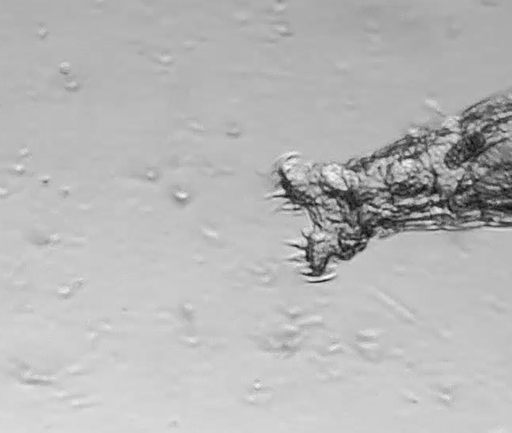

In [23]:
#capture_frames = [[60,95],[1305,1349],[1553,1611],[1737,1777],[1817,1899],[1863,1913]]

@pims.pipeline
def crop(img, bbox):
    """
    Crop the image to select the region of interest
    """
    xmin, xmax, ymin, ymax = bbox
    return img[ymin:ymax, xmin:xmax]

zoom_in = [750, 1400, 350, 900] 

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(crop(pims.open(img_seq_folder), zoom_in))
fstart, fend = 1305, 1899
use_frames = np.arange(fstart, fend)
frames[fstart]

In [24]:
img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

real width (µm):  393.94 
real height (µm): 333.33


n features -  75


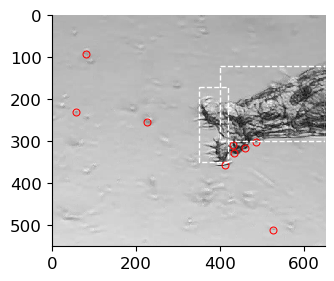

In [49]:
locate_params = {
    "diameter" : 13,
    "threshold" : 5,
    "invert" : True,
}
frame_nr = fstart
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# Rotifer exclude
# make it a polygon!!!
rotifer_bbox = [400, img_width, 120, 300]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]

# Detritus exclude
#detritus_bbox = [385, 430, 200, 350]
detritus_bbox = [350, 420, 170, 350]
detritus_condition = (f.x > detritus_bbox[0]) & (f.x < detritus_bbox[1]) & (f.y > detritus_bbox[2]) & (f.y < detritus_bbox[3])
f = f[~detritus_condition]


fig, ax = plt.subplots()
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});

# # BBoxes to exclude
plot_bbox(rotifer_bbox)
plot_bbox(detritus_bbox)

Frame([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
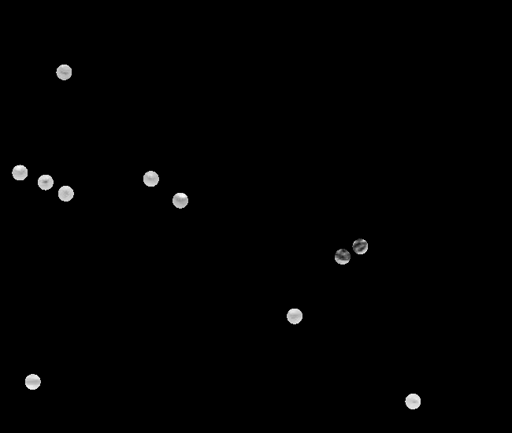

In [40]:
tp.masks.mask_image(f[["y", "x"]].values, frames[frame_nr], 10)#, invert=True

In [50]:
tp.quiet()
fbatch = tp.batch(frames[use_frames], **locate_params)

rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
fbatch = fbatch[~rotifer_condition]

# Detritus exclude
detritus_condition = (fbatch.x > detritus_bbox[0]) & (fbatch.x < detritus_bbox[1]) & (fbatch.y > detritus_bbox[2]) & (fbatch.y < detritus_bbox[3])
fbatch = fbatch[~detritus_condition]

fbatch

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,91.587930,80.721609,498.751142,3.205487,0.539385,18.124636,-13895.2369,0.113349,1305
31,230.472670,57.344534,722.396203,2.364235,0.246457,35.601963,-14966.0596,0.211318,1305
43,253.346211,227.311293,871.277141,3.512026,0.429597,19.742907,-13928.4121,0.115001,1305
62,300.099582,486.089624,1007.535564,3.299924,0.559954,32.365421,-12012.6890,0.062450,1305
65,307.984567,431.058355,1342.194020,3.169590,0.490358,49.195440,-9345.1932,0.038166,1305
...,...,...,...,...,...,...,...,...,...
47597,201.726663,344.519843,1157.482796,3.327142,0.509626,39.466993,-13799.2208,0.106607,1898
47624,244.358031,234.015026,624.354890,2.768064,0.472905,28.144495,-15509.7435,0.359659,1898
47640,271.951042,240.254484,667.380382,3.385264,0.486306,20.380496,-14830.0677,0.185087,1898
47646,311.878261,64.352657,334.822441,2.133922,0.345717,21.997996,-15989.1969,1.074699,1898


In [51]:
link_params = {
    "search_range" : 50,  # within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(5); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 301
5
N Before: 301 
 N after filtering: 167


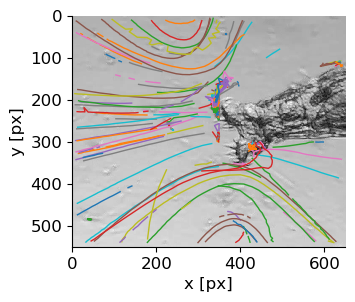

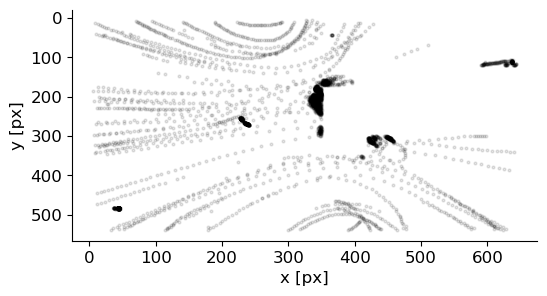

In [53]:
# This plots trajectories with associated particle number
fig, ax = plt.subplots()
tp.plot_traj(trajs, superimpose=frames[frame_nr], label=False, ax=ax);#, label=True

fig, ax = plt.subplots()
tp.scatter(trajs, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"});
#ax.set(**ax_params); ax.invert_yaxis(); ax.invert_xaxis()

In [54]:
# Re-Calculate stats and reject more based on std of spatial position
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std < 5) | (stats.y_std < 5)  #reject_idx = (stats.x_std < 20) | (stats.y_std < 20)
reject_prts = stats.particle[reject_idx].to_numpy()  #reject_prts = np.append(reject_prts, [56, 81]) 

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
#num_filtered_particles = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
num_particles_rejected = traj_rejected.particle.nunique()
print("number of particles (original):", num_ori_particles, #"\nnumber of filtered particles:", num_filtered_particles,
      "\nnumber of rejected particles:", num_particles_rejected, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj)
print(len(stats))

number of particles = number of trajectories: 167
number of particles (original): 167 
number of rejected particles: 96 
number of particles remaining: 71
number of particles = number of trajectories: 71
71


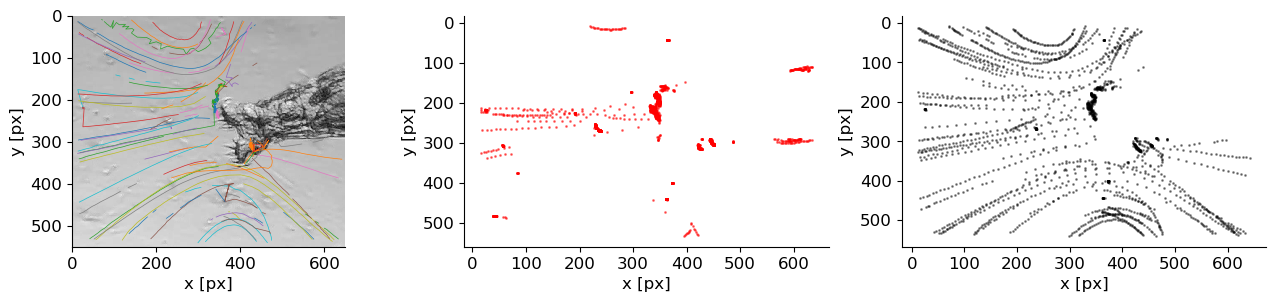

In [46]:
fig, ax = plt.subplots(1,3, figsize=(16, 3))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=False, ax=ax[0], plot_style={"lw" : .5}); #ax[0].set(**ax_params); 

#tp.scatter(ctraj, ax=ax[1], plot_style={"ms" : 1, "alpha" : .4, "color" : "k", "label" : "accepted"});
tp.scatter(traj_rejected, ax=ax[1], plot_style={"ms" : 1, "alpha" : .5, "color" : "r", "label" : "rejected"})
#ax[1].set(**ax_params); ax[1].invert_yaxis(); ax[1].invert_xaxis(); ax[1].legend()

tp.scatter(ctraj, ax=ax[2], plot_style={"ms" : 1, "alpha" : .4, "color" : "k", "label" : "accepted"});
#ax[2].set(**ax_params); ax[2].invert_yaxis(); ax[2].invert_xaxis()

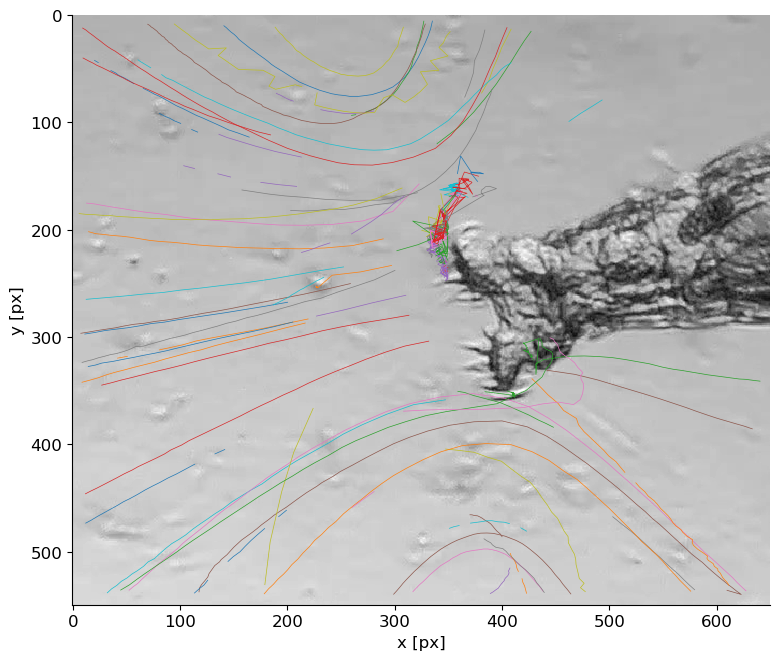

In [55]:
traj_bbox = [250, 600, 50, 500]
ax_params = dict(xlim=(250, 600), ylim=(50, 500))

fig, ax = plt.subplots(figsize=(9, 9))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=False, ax=ax, plot_style={"lw" : .5}); 
#ax.set(**ax_params); 

#plot at center of mass with std in both directions!

In [65]:
corona_center = (400, 375)

func = lambda i: i.diff()
# Calculate the differences in x and y positions, and time using transform
points = ctraj[["x", "y"]].to_numpy()

ctraj['dx'] = ctraj.groupby('particle')['x'].transform(func)
ctraj['dy'] = ctraj.groupby('particle')['y'].transform(func)
velocities = ctraj[["dx", "dy"]].to_numpy()

ctraj['velocity'] = np.sqrt(ctraj['dx']**2 + ctraj['dy']**2)# / df['frame_diff']
ctraj['rdist'] = np.sqrt((ctraj['x'] - corona_center[0]) **2 + (ctraj['y'] - corona_center[1]) **2)
bins = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), 30)
ctraj['rbin'] = pd.cut(ctraj['rdist'], bins)
ctraj_ = ctraj.dropna()
bin_stats = ctraj_.groupby('rbin', observed=True)['velocity'].agg(['mean', 'std', 'count'])
bin_centers = [round(interval.mid, 1) for interval in bin_stats.index.categories]
n_frames = ctraj_.groupby('particle')['frame'].count()
n_frames.sort_values(ascending=False)

particle
258    94
70     91
137    89
245    88
144    86
       ..
0       6
194     5
251     4
178     4
154     4
Name: frame, Length: 71, dtype: int64

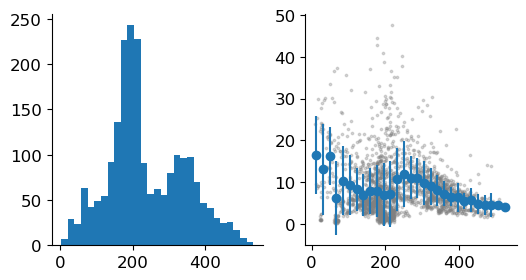

In [66]:
fig, ax = plt.subplots(1,2)
ax[0].bar(bin_centers, bin_stats['count'].values, width=np.diff(bins)[0])

ax[1].errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'], fmt='o', label='Average Velocity')
ax[1].scatter(ctraj_['rdist'], ctraj_['velocity'], alpha=0.3, color='gray', s=3, label='Individual Velocities')


[[<matplotlib.axis.YTick at 0x157e13fa0>,
 [Text(1, 0.0, 'min'), Text(1, 5.311723363240288, 'max')]]

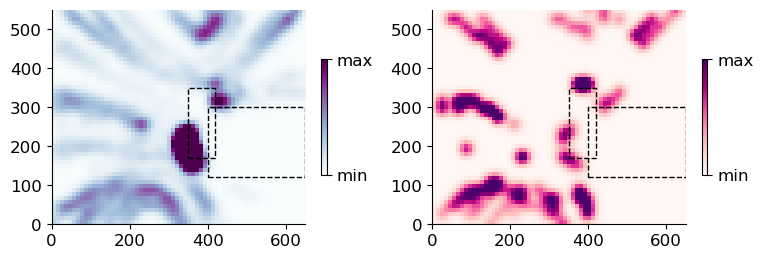

In [68]:
SAVE_FIGURES = False
bin_size_2d = 20
sigma_2d = 1

cmap = plt.cm.BuPu; cmap.set_bad(color=(0, 0, 0, 0))
cmap2 = plt.cm.RdPu; cmap2.set_bad(color=(0, 0, 0, 0)) 
v_xy = ctraj['velocity'].to_numpy()
#velocities = ctraj['velocity'].to_numpy()
occupancy_map, x_edges, y_edges = construct_occupancy_map(points, img_height, img_width, bin_size_2d)
interpolated_omap, new_x_edges, new_y_edges = interpolate_2d_map(occupancy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
velocity_map, x_edges, y_edges = construct_velocity_map(points, v_xy, img_height, img_width, bin_size_2d, threshold_count=5)
interpolated_vmap, new_x_edges, new_y_edges = interpolate_2d_map(velocity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)

vvmax = np.percentile(interpolated_vmap, 98)
ovmax = np.percentile(interpolated_omap, 98)

fig, ax = plt.subplots(1,2, figsize=(9, 3))
cax = ax[0].imshow(interpolated_omap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap, vmin=0, vmax=ovmax)
plot_bbox(rotifer_bbox, "k", ax=ax[0]); plot_bbox(detritus_bbox, "k", ax=ax[0])
#ax[0].set(**ax_params); #ax[0].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, ovmax], yticklabels=["min", "max"])

cax = ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap2, vmin=0, vmax=vvmax)
plot_bbox(rotifer_bbox, "k", ax=ax[1]); plot_bbox(detritus_bbox, "k", ax=ax[1])
#ax[1].set(**ax_params); #ax[1].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, vvmax], yticklabels=["min", "max"])

#fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-occupancy-velocity-2Dmaps.jpg", **fig_params) if SAVE_FIGURES else None
#print("percentiles vmap:", vvmax, "\nomap", ovmax)

In [70]:
from scipy.interpolate import griddata
# Define grid for velocity field
grid_x, grid_y = np.meshgrid(np.arange(0, img_width, 10), np.arange(0, img_height, 10))

# Interpolate velocities onto grid
grid_u = griddata(points, velocities[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points, velocities[:, 1], (grid_x, grid_y), method='linear')

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)

print(np.nanmin(omega), np.nanmax(omega))

-2.2894914325692723 2.023721114282445


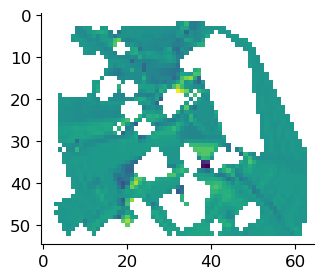

In [72]:
plt.imshow(omega)

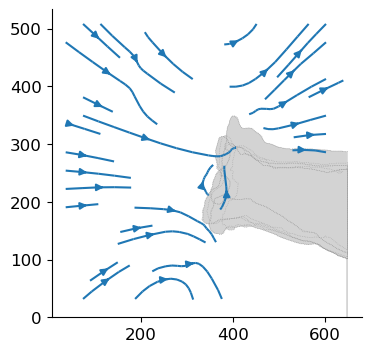

In [71]:
normalize=False
fig, ax = plt.subplots(figsize=(4,4))
for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt.copy())
    if normalize:
        cnt[:,0] = cnt[:,0] - df_stats.loc[nth, "centroid_x"]
        cnt[:,1] = cnt[:,1] - df_stats.loc[nth, "centroid_y"]
    ax.fill_between(cnt[:,0], cnt[:,1], facecolor="lightgray")  #, lw=1, edgecolor="gray", linestyle="--")
    ax.plot(cnt[:,0], cnt[:,1], ":", color="gray", alpha=.5, lw=.5)

plt.streamplot(grid_x, grid_y, grid_u, grid_v, density=.6)
#plt.gca().invert_yaxis()